## 1. Set Environment & Check Data

In [89]:
# Import libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Ensure reproductibility
SEED = 42
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load the data
df = pd.read_csv("chiller_data.csv")

# Have an idea of it
df.head()

,month,day_of_month,hour,outdoor_temperature,outdoor_humidity,wind_speed,wind_direction,diffuse_solar_radiation,direct_solar_radiation,air_temperature,air_humidity,people_occupant,htg_setpoint,clg_setpoint,co2_emission,HVAC_electricity_demand_rate,total_electricity_HVAC
0,1.0,1.0,0.0,-9.747895,46.072880,8.4,305.0,0.0,0.0,16.715874,30.563377,0.0,12.8,40.0,0.0,3210.689697,2889620.750
1,1.0,1.0,0.0,-7.965263,52.381920,8.0,290.0,0.0,0.0,16.597004,30.265848,0.0,14.0,28.0,0.0,5605.557129,5246710.000
2,1.0,1.0,0.0,-6.182631,58.690960,7.6,275.0,0.0,0.0,16.536865,30.134699,0.0,13.0,29.0,0.0,2603.134521,2342821.250
3,1.0,1.0,0.0,-4.400000,65.000000,7.2,260.0,0.0,0.0,16.479002,29.905802,0.0,12.0,30.0,0.0,2281.072998,2052965.750
4,1.0,1.0,1.0,-4.271313,66.063713,6.7,262.5,0.0,0.0,16.435146,29.798470,0.0,12.0,30.0,0.0,2294.669189,2065202.375


## 2. Initialize Variables

In [90]:
# Define target and features
target_col = "total_electricity_HVAC"
feature_cols = [col for col in df.columns if col != target_col]

# Store their values
x_all = df[feature_cols].values # Feature values
y_all = np.log1p(df[target_col].values).reshape(-1, 1) # Target values (avoiding negative values with log1p)

# Check
print(f"Target column ({y_all.shape[1]}): {target_col}")
print(f"Feature columns ({x_all.shape[1]}): {feature_cols}\n")

# Split the data into training and testing sets (80% train, 20% test)
split_index = int(0.8 * len(df))
x_train_raw, x_test_raw = x_all[:split_index], x_all[split_index:] # Still raw because we need to standardize values
y_train_raw, y_test_raw = y_all[:split_index], y_all[split_index:] # Same

# Standardize the variables
scaler_x = StandardScaler()
scaler_y = StandardScaler()
x_train = scaler_x.fit_transform(x_train_raw)
x_test = scaler_x.transform(x_test_raw) # Non-fitting to avoid data leakage (standardize with training set mean and std)
y_train = scaler_y.fit_transform(y_train_raw)
y_test = scaler_y.transform(y_test_raw) # Same

# Check
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}\n")

# Every prevision will be based on features data of the last 2 hours (4 time steps)
lookback = 4

# Create 6-hours windows with past data
def make_sequences(x, y, lookback):
    x_seq, y_seq = [], []
    for t in range(lookback, len(x)):
        x_past = x[t - lookback:t]
        y_past = y[t - lookback:t]
        # Add past target values as features
        seq = np.concatenate((x_past, y_past), axis=1)
        x_seq.append(seq)
        y_seq.append(y[t])
    return np.array(x_seq), np.array(y_seq)

# Create sequences for training and testing sets
x_train_seq, y_train_seq = make_sequences(x_train, y_train, lookback)
x_test_seq, y_test_seq = make_sequences(x_test, y_test, lookback)

n_timesteps = x_train_seq.shape[1]
n_features = x_train_seq.shape[2]

# Check
print(f"Number of created sequences - Training: {x_train_seq.shape[0]} Testing: {x_test_seq.shape[0]}")
print(f"Timesteps per sequence: {n_timesteps}")
print(f"Features per timestep: {n_features}\n")

Target column (1): total_electricity_HVAC
Feature columns (16): ['month', 'day_of_month', 'hour', 'outdoor_temperature', 'outdoor_humidity', 'wind_speed', 'wind_direction', 'diffuse_solar_radiation', 'direct_solar_radiation', 'air_temperature', 'air_humidity', 'people_occupant', 'htg_setpoint', 'clg_setpoint', 'co2_emission', 'HVAC_electricity_demand_rate']

x_train shape: (280320, 16), x_test shape: (70080, 16)
y_train shape: (280320, 1), y_test shape: (70080, 1)

Number of created sequences - Training: 280316 Testing: 70076
Timesteps per sequence: 4
Features per timestep: 17



## 3. Model Structure & Training

In [91]:
# Structure
model = Sequential([
    LSTM(64, input_shape=(n_timesteps, n_features), return_sequences=True),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1) # Prediction 
])
model.compile(optimizer='adam', loss='mae') # MAE is better with peaks

# Check
model.summary()

# Set EarlyStopping to avoid useless training
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    x_train_seq, y_train_seq,
    epochs=20,
    batch_size=32,
    validation_data=(x_test_seq, y_test_seq),
    callbacks=[es],
    verbose=1,
    shuffle=False # As it's time series data
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 4, 64)          │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,953 (132.63 KB)

 Trainable params: 33,953 (132.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-11-18 18:38:22.171734: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-11-18 18:38:22.172087: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

8742/8760 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3261

2025-11-18 18:38:37.221949: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-11-18 18:38:37.222316: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

8760/8760 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.3260 - val_loss: 0.2272
Epoch 2/20
8760/8760 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.2050 - val_loss: 0.1864
Epoch 3/20
8760/8760 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.1845 - val_loss: 0.1754
Epoch 4/20
8760/8760 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.1761 - val_loss: 0.1610
Epoch 5/20
8760/8760 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.1692 - val_loss: 0.1544
Epoch 6/20
8760/8760 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.1659 - val_loss: 0.1478
Epoch 7/20
8760/8760 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.1636 - val_loss: 0.1460
Epoch 8/20
8760/8760 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.1607 - val_loss: 0.1357
Epoch 9/20
8760/8760 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.1560 - val_loss: 0.1333
Epoch 10/20
8760/8760 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.1531 - val_loss: 0.1311
Epoch 11/20
8760/8760 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.1519 - val_loss: 0.1302
Epoch 12/20
8760/8760 ━━━━━━━━

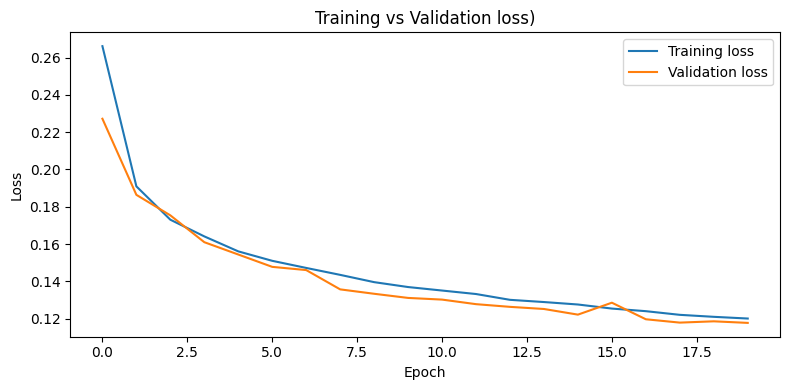

In [92]:
# Keep track of the losses
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot learning curves
plt.figure(figsize=(8, 4))
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation loss)')
plt.legend()
plt.tight_layout()
plt.show()

## 4. Results & Model Evaluation

In [93]:
# Predictions on the test
y_pred_test_scaled = model.predict(x_test_seq, verbose=0)

# Remove standardization 
y_true_log = scaler_y.inverse_transform(y_test_seq)
y_pred_log = scaler_y.inverse_transform(y_pred_test_scaled)
# Removing logarithm -1 (go back to original units)
y_true_inv = np.expm1(y_true_log).ravel()   
y_pred_inv = np.expm1(y_pred_log).ravel()

# Remove total outliers 
perc_error = (y_pred_inv - y_true_inv) / y_true_inv * 100
mask = np.abs(perc_error) <= 100  # Keep only errors within ±100%. The other predictions are considered outliers

# Print how many points are removed and kept
print("\nTotal data points:", len(y_pred_inv))
print("Removed data points:", (~mask).sum())
print("Kept data point:", mask.sum())

# Actual and Predicted values we will work with
y_pred = y_pred_inv[mask]
y_true = y_true_inv[mask]

# Evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
print(f"\nLSTM -> MAE {mae:.3f}, RMSE {rmse:.3f}, R² {r2:.3f}")

2025-11-18 18:43:36.444692: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-11-18 18:43:36.445695: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Total data points: 70076
Removed data points: 2082
Kept data point: 67994

LSTM -> MAE 242504.680, RMSE 786443.694, R² 0.923


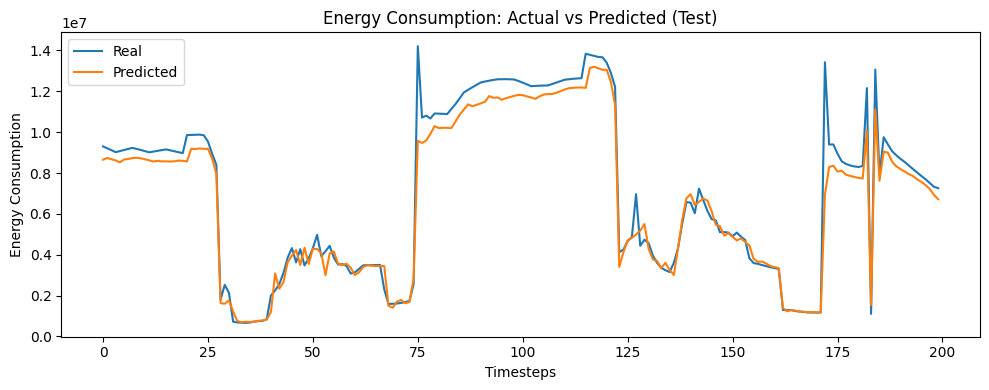

In [94]:
# Grapical comparison between real and predicted values (first 200 samples)
plt.figure(figsize=(10, 4))
plt.plot(y_true[:200], label='Real', linewidth=1.5)
plt.plot(y_pred[:200], label='Predicted', linewidth=1.5)
plt.xlabel('Timesteps')
plt.ylabel('Energy Consumption')
plt.title('Energy Consumption: Actual vs Predicted (Test)')
plt.legend()
plt.tight_layout()
plt.show()

In [95]:
# Non-graphical results
results = pd.DataFrame({
    'Actual': y_true.flatten(),
    'Predicted': y_pred.flatten(),
})

# Look if everything is ok
results['PercError'] = (results['Predicted'] - results['Actual']) / results['Actual'] * 100

print(results['PercError'].describe())

count    67994.000000
mean        -0.619421
std         18.570326
min        -99.295072
25%         -2.309308
50%          0.703710
75%          4.414993
max         99.985937
Name: PercError, dtype: float64
